In [1]:
import lightgbm as lgb
import os
import math
import pandas as pd
import numpy as np
import random
import gc
from datetime import datetime
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import  OneHotEncoder

np.random.seed(2019)
random.seed(2019)
pd.set_option('display.max_rows', 6)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 280)
pd.set_option('display.max_colwidth', 150)
data_path = '/data/workspace/kimi/tencent_ads/2020/dataset'
preprocess_path = 'preprocess'

In [2]:
user_base_statics_df= pd.read_pickle(f'{preprocess_path}/train_user_base_statics.pkl')
user_base_statics_df.columns = ['_'.join(i) for i in user_base_statics_df.columns.values]
label_df = pd.read_csv(f'{data_path}/train_preliminary/user.csv')
user_base_statics_df = user_base_statics_df.merge(label_df,on='user_id')
user_base_statics_df['click_times_sum_log'] = user_base_statics_df['click_times_sum'].apply(lambda x :math.log(x))
user_base_statics_df['click_times_count_log'] = user_base_statics_df['click_times_count'].apply(lambda x :math.log(x))
user_base_statics_df['age'] = user_base_statics_df['age'] -1
user_base_statics_df = user_base_statics_df.astype(float)
print(user_base_statics_df)


         user_id  click_times_sum  click_times_count  ad_id_nunique  product_id_nunique  ...  industry_nunique  age  gender  click_times_sum_log  click_times_count_log
0            1.0             14.0               13.0           12.0                 6.0  ...               9.0  3.0     1.0             2.639057               2.564949
1            2.0             46.0               45.0           42.0                20.0  ...              15.0  9.0     1.0             3.828641               3.806662
2            3.0             30.0               30.0           30.0                17.0  ...               8.0  6.0     2.0             3.401197               3.401197
...          ...              ...                ...            ...                 ...  ...               ...  ...     ...                  ...                    ...
899997  899998.0             15.0               14.0           14.0                 5.0  ...               5.0  3.0     2.0             2.708050               2

In [3]:
train_df = user_base_statics_df[user_base_statics_df.user_id <= 720000]
valid_df = user_base_statics_df[user_base_statics_df.user_id > 720000]
valid_df = valid_df[valid_df.user_id < 2000000]
print(valid_df)


         user_id  click_times_sum  click_times_count  ad_id_nunique  product_id_nunique  ...  industry_nunique  age  gender  click_times_sum_log  click_times_count_log
720000  720001.0             32.0               28.0           26.0                11.0  ...              11.0  2.0     2.0             3.465736               3.332205
720001  720002.0             29.0               29.0           26.0                 2.0  ...              19.0  1.0     2.0             3.367296               3.367296
720002  720003.0             21.0               20.0           17.0                 8.0  ...              10.0  1.0     1.0             3.044522               2.995732
...          ...              ...                ...            ...                 ...  ...               ...  ...     ...                  ...                    ...
899997  899998.0             15.0               14.0           14.0                 5.0  ...               5.0  3.0     2.0             2.708050               2

In [4]:
def merge_features(train_df,valid_df,train_file,valid_file,target_encode=False):
    train_features_df  = pd.read_pickle(f'{preprocess_path}/{train_file}')
    valid_features_df = pd.read_pickle(f'{preprocess_path}/{valid_file}')
    if target_encode:
        train_features_df.columns = [ '_'.join(i) for i in train_features_df.columns.values  ]
        valid_features_df.columns = ['_'.join(i) for i in valid_features_df.columns.values  ]

    train_df = train_df.merge(train_features_df,on='user_id')
    valid_df = valid_df.merge(valid_features_df,on='user_id')
    return train_df,valid_df


In [5]:
for i in ['creative_id','ad_id', 'product_id','advertiser_id','industry','product_category']:
    print(f'merge {i}...')
    train_df,valid_df = merge_features(train_df,valid_df,f'train_user_target_encoder_{i}_age.pkl',f'valid_user_target_encoder_{i}.pkl',True)
    print(train_df)
    print(valid_df)

merge creative_id...
         user_id  click_times_sum  click_times_count  ad_id_nunique  product_id_nunique  ...  creative_id_age8_kfold_mean_std  creative_id_age9_kfold_mean_min  creative_id_age9_kfold_mean_max  creative_id_age9_kfold_mean_mean  creative_id_age9_kfold_mean_std
0            1.0             14.0               13.0           12.0                 6.0  ...                         0.022296                              0.0                         0.061728                          0.016455                         0.020560
1            2.0             46.0               45.0           42.0                20.0  ...                         0.026155                              0.0                         0.500000                          0.029619                         0.074746
2            3.0             30.0               30.0           30.0                17.0  ...                         0.061345                              0.0                         0.053333           

In [6]:
def merge_w2v_features(train_df,valid_df,train_file,valid_file,f=None,target_encode=False):
    train_features_df  = pd.read_pickle(f'{preprocess_path}/{train_file}').drop([f'{f}_top0_{i}'  for i in range(64)],axis=1)
    print(train_features_df)
    valid_features_df = pd.read_pickle(f'{preprocess_path}/{valid_file}').drop([f'{f}_top0_{i}'  for i in range(64)],axis=1)
    if target_encode:
        train_features_df.columns = [ '_'.join(i) for i in train_features_df.columns.values  ]
        valid_features_df.columns = ['_'.join(i) for i in valid_features_df.columns.values  ]

    train_df = train_df.merge(train_features_df,on='user_id')
    valid_df = valid_df.merge(valid_features_df,on='user_id')
    return train_df,valid_df


In [7]:
# for i in ['creative_id','ad_id', 'product_id','advertiser_id','industry']:
#     print(f'merge {i}...' )
#     #creative_id_top1_s64_clk.pkl
#     train_df,valid_df = merge_w2v_features(train_df,valid_df,f'{i}_top1_s64_clk.pkl',f'{i}_top1_s64_clk.pkl',i,False)
#     print(train_df)
#     print(valid_df)

In [8]:
drop_list = ['age','user_id','gender','click_times_sum','click_times_count']
train_x = train_df.drop(drop_list, axis=1)
train_y = train_df['age'].astype(int)

valid_x = valid_df.drop(drop_list, axis=1)
valid_y = valid_df['age'].astype(int)
#print(x)
#print(y)
print(train_x)
print(train_y)

print(valid_x)
print(valid_y)

#train_x,valid_x,train_y,valid_y =  train_test_split(x,y,test_size=0.20, random_state=42)
#print(train_x.shape)
train_data = lgb.Dataset(train_x.values, label=train_y, feature_name=list(train_x.columns),free_raw_data=False)
valid_data = lgb.Dataset(valid_x.values, label=valid_y, feature_name=list(train_x.columns),free_raw_data=False,reference=train_data)



        ad_id_nunique  product_id_nunique  product_category_nunique  advertiser_id_nunique  industry_nunique  ...  product_category_age8_kfold_mean_std  product_category_age9_kfold_mean_min  product_category_age9_kfold_mean_max  product_category_age9_kfold_mean_mean  \
0                12.0                 6.0                       3.0                   12.0               9.0  ...                              0.002065                              0.009877                              0.015052                               0.012807   
1                42.0                20.0                       3.0                   36.0              15.0  ...                              0.014790                              0.013372                              0.091313                               0.017904   
2                30.0                17.0                       6.0                   28.0               8.0  ...                              0.013904                              0.013372 

In [9]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'softmax',
    'num_class':10,
    'metric': 'multi_error',
    'num_leaves': 64 + 1,
    'learning_rate': 0.1,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 5,
    'lambda_l2':0.03,
    'verbose': 1
}
print('Starting training...')
# train

gbm = lgb.train(params,
                train_data,
                 valid_sets=[train_data,valid_data],
                num_boost_round = 2000,
                early_stopping_rounds=20
               )
gbm.save_model('model/age_target.model')
print('Feature importances:', list(gbm.feature_importance()))

Starting training...
[1]	training's multi_error: 0.774033	valid_1's multi_error: 0.772856
Training until validation scores don't improve for 20 rounds.
[2]	training's multi_error: 0.754706	valid_1's multi_error: 0.753522
[3]	training's multi_error: 0.728668	valid_1's multi_error: 0.727589
[4]	training's multi_error: 0.698711	valid_1's multi_error: 0.698578
[5]	training's multi_error: 0.667114	valid_1's multi_error: 0.669089
[6]	training's multi_error: 0.644085	valid_1's multi_error: 0.648806
[7]	training's multi_error: 0.628249	valid_1's multi_error: 0.634011
[8]	training's multi_error: 0.616332	valid_1's multi_error: 0.623106
[9]	training's multi_error: 0.608103	valid_1's multi_error: 0.615833
[10]	training's multi_error: 0.601772	valid_1's multi_error: 0.6107
[11]	training's multi_error: 0.597017	valid_1's multi_error: 0.6066
[12]	training's multi_error: 0.592935	valid_1's multi_error: 0.603872
[13]	training's multi_error: 0.589804	valid_1's multi_error: 0.600944
[14]	training's mult

In [42]:
before_one_hot =  train_y.values.reshape([-1,1])
print(before_one_hot)
enc = OneHotEncoder()
enc.fit(before_one_hot)

one_hoted_y  = enc.transform(before_one_hot).toarray()
print(one_hoted_y.shape)


[[3]
 [9]
 [6]
 ...
 [3]
 [3]
 [4]]
(720000, 10)


/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [80]:
class_num=10
weights = [1.0]*class_num

def search_weight(valid_y, raw_prob, init_weight=[1.0]*class_num, step=0.001):
    #print(valid_y)
    #print(raw_prob)
    #print(get_max(raw_prob))
    weight = init_weight.copy()
    f_best = precision_score(valid_y,get_max(raw_prob),average='micro')
    flag_score = 0
    round_num = 0
    while(flag_score != f_best):
        round_num += 1
        flag_score = f_best
        for c in range(class_num):
            last_best = 0
            for n_w in range(0, 1000,10):
                print(f"round: { round_num} bast :{round(f_best,5)} class:{c} weight factor:{n_w}")
                num = n_w * step
                new_weight = weight.copy()
                prob_df = raw_prob.copy()
                
                new_weight[c] = num + 1
                prob_df_test = prob_df * np.array(new_weight)
                f = precision_score(valid_y, get_max(prob_df_test),average='micro')
                if f > f_best:
                    weight = new_weight.copy()
                    f_best = f
                    print(f)
                    last_best = n_w
                    
                new_weight[c] = 1-num
                prob_df_test = prob_df * np.array(new_weight)
                f = precision_score(valid_y, get_max(prob_df_test),average='micro')
                if f > f_best:
                    weight = new_weight.copy()
                    f_best = f
                    print(f)
                    last_best = n_w
                if last_best!= 0 and (n_w - last_best) > 100:
                    print("break loop")
                    break
                    
                if last_best ==  0 and (n_w - last_best) > 300:
                    print("break loop")
                    break
    return weight

def get_max(y_pred):
    y_pred = y_pred.copy()
    for i in range(len(y_pred)):
        max_value=max(y_pred[i])
        for j in range(len(y_pred[i])):
            if max_value==y_pred[i][j]:
                y_pred[i][j]=1
            else:
                y_pred[i][j]=0
    return y_pred

In [ ]:
y_pred = gbm.predict(train_x.astype(float))

In [54]:




# print(precision_score(one_hoted_y, y_pred,average='micro'))

# ret = []
# for user_id,age,age_percent,label_age in zip(range(1000000),y_pred,y_pred_percent,train_y):
#     ret.append([int(user_id) + 1,int(age.tolist().index(1) + 1),age_percent,label_age])
# ret_df = pd.DataFrame(ret,columns=['user_id','predicted_age','age_percent','label_age'])
# print(ret_df)
# ret_df.to_pickle('output/lgb_train_output.pkl')



[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[3.53664394e-03 3.36138142e-02 1.04722952e-01 ... 2.86928441e-02
  6.72862216e-03 1.16441237e-03]
 [1.36658306e-02 8.62958936e-02 2.54367925e-01 ... 1.22918754e-02
  7.50854348e-03 1.15318067e-01]
 [1.10323758e-03 3.80623865e-03 1.86792138e-02 ... 1.68466742e-02
  4.87298589e-03 1.79694720e-04]
 ...
 [1.06388180e-02 2.94991782e-02 7.22343665e-01 ... 5.87908241e-04
  1.55580430e-04 3.58633682e-05]
 [5.39735918e-02 6.26949631e-01 1.93202321e-01 ... 8.67947836e-04
  3.26347871e-04 1.83447043e-04]
 [1.24430121e-02 5.92278648e-02 2.38283421e-01 ... 1.45663107e-02
  1.95649117e-03 2.71023182e-04]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
round: 1 bast :0.4836111111111111 


KeyboardInterrupt: 

In [11]:

y_pred = gbm.predict(train_x.astype(float))
y_pred_percent = y_pred.copy()
for i in range(len(y_pred)):
        max_value=max(y_pred[i])
        for j in range(len(y_pred[i])):
            if max_value==y_pred[i][j]:
                y_pred[i][j]=1
            else:
                y_pred[i][j]=0
                
print(precision_score(one_hoted_y, y_pred,average='micro'))

ret = []
for user_id,age,age_percent,label_age in zip(range(1000000),y_pred,y_pred_percent,train_y):
    ret.append([int(user_id) + 1,int(age.tolist().index(1) + 1),age_percent,label_age])
ret_df = pd.DataFrame(ret,columns=['user_id','predicted_age','age_percent','label_age'])
print(ret_df)
ret_df.to_pickle('output/lgb_train_output.pkl')


0.4836111111111111
        user_id  predicted_age                                                                                                                                            age_percent  label_age
0             1              4  [0.003536643937212133, 0.033613814158750414, 0.10472295247815293, 0.3142868119270023, 0.2369830819673091, 0.1934341204826632, 0.07683669638245794,...          3
1             2              3  [0.013665830597264441, 0.08629589355866997, 0.2543679249094103, 0.22024724377106586, 0.17575129149083857, 0.07047828631294545, 0.04407504370600985...          9
2             3              5  [0.001103237578236013, 0.0038062386548998626, 0.018679213781333876, 0.12546615002012973, 0.35154122041565783, 0.28290024989371776, 0.1946043348043...          6
...         ...            ...                                                                                                                                                    ...        ...
719997   719998 

In [55]:

before_one_hot =  valid_y.values.reshape([-1,1])
print(before_one_hot)
enc = OneHotEncoder()
enc.fit(before_one_hot)

one_hoted_y  = enc.transform(before_one_hot).toarray()
print(one_hoted_y.shape)


[[2]
 [1]
 [1]
 ...
 [3]
 [2]
 [2]]
(180000, 10)


/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [81]:
#y_pred = gbm.predict(valid_x.astype(float))
# y_pred_precent =  y_pred.copy()
# for i in range(len(y_pred)):
#         max_value=max(y_pred[i])
#         for j in range(len(y_pred[i])):
#             if max_value==y_pred[i][j]:
#                 y_pred[i][j]=1
#             else:
#                 y_pred[i][j]=0
                
#precision_score(one_hoted_y, y_pred,average='micro')

searched_weight =  search_weight(one_hoted_y,y_pred)
print(searched_weight)

round: 2 bast :0.43221 class:0 weight factor:0
round: 2 bast :0.43221 class:0 weight factor:10
round: 2 bast :0.43221 class:0 weight factor:20
0.4322722222222222
round: 2 bast :0.43227 class:0 weight factor:30
0.43228333333333335
round: 2 bast :0.43228 class:0 weight factor:40
round: 2 bast :0.43228 class:0 weight factor:50
round: 2 bast :0.43228 class:0 weight factor:60
0.43230555555555555
round: 2 bast :0.43231 class:0 weight factor:70
round: 2 bast :0.43231 class:0 weight factor:80
round: 2 bast :0.43231 class:0 weight factor:90
round: 2 bast :0.43231 class:0 weight factor:100
round: 2 bast :0.43231 class:0 weight factor:110
round: 2 bast :0.43231 class:0 weight factor:120
round: 2 bast :0.43231 class:0 weight factor:130
round: 2 bast :0.43231 class:0 weight factor:140
round: 2 bast :0.43231 class:0 weight factor:150
round: 2 bast :0.43231 class:0 weight factor:160
round: 2 bast :0.43231 class:0 weight factor:170
break loop
round: 2 bast :0.43231 class:1 weight factor:0
round: 2 bas

In [14]:
ret = []
for user_id,age,age_percent,label_age in zip(range(1000000),y_pred,y_pred_precent,valid_y):
    ret.append([int(user_id + 720001),int(age.tolist().index(1)),age_percent,label_age])
ret_df = pd.DataFrame(ret,columns=['user_id','predicted_age','age_percent','label_age'])
print(ret_df)
print(ret_df['predicted_age'].value_counts())
ret_df.to_pickle('output/lgb_valid_output.pkl')

        user_id  predicted_age                                                                                                                                            age_percent  label_age
0        720001              2  [0.011335196427501073, 0.23627500626493914, 0.331160012982333, 0.21351024787377573, 0.15229815865588456, 0.04212763082810431, 0.007652770376687205...          2
1        720002              1  [0.005486145879664597, 0.4386906909430863, 0.33534911500371994, 0.17120078036978487, 0.03421252861109252, 0.009436647439243141, 0.0039406284650587...          1
2        720003              1  [0.09556113099191825, 0.7135691085038124, 0.1562696164046333, 0.028107796868440678, 0.00481075339347052, 0.0008853170738319001, 0.0005341910687160...          1
...         ...            ...                                                                                                                                                    ...        ...
179997   899998              3  [0.

In [15]:
user_age1_df = ret_df[ret_df.label_age == 0 ]['predicted_age'].value_counts()
pd.set_option('display.max_rows', 10)
print(user_age1_df)

0    3155
1    2711
2     677
3     120
4     105
5     101
6      89
7      39
8      25
9      23
Name: predicted_age, dtype: int64


In [16]:
user_age1_df = ret_df[ret_df.label_age == 1 ]['predicted_age'].value_counts()
pd.set_option('display.max_rows', 10)
print(user_age1_df)


1    18301
2     8434
3     1027
0      806
4      630
5      307
6      165
7       62
8       56
9       46
Name: predicted_age, dtype: int64


In [17]:
user_age1_df = ret_df[ret_df.label_age == 2 ]['predicted_age'].value_counts()
pd.set_option('display.max_rows', 10)
print(user_age1_df)

2    22872
1     7836
3     5875
4     2205
5      959
6      357
0      290
7      151
8      145
9       81
Name: predicted_age, dtype: int64


In [18]:
user_age1_df = ret_df[ret_df.label_age == 3 ]['predicted_age'].value_counts()
pd.set_option('display.max_rows', 10)
print(user_age1_df)

3    11095
2    10216
4     4588
1     1638
5     1534
6      449
7      167
8      155
0      109
9      108
Name: predicted_age, dtype: int64


In [19]:
user_age1_df = ret_df[ret_df.label_age == 4 ]['predicted_age'].value_counts()
pd.set_option('display.max_rows', 10)
print(user_age1_df)

4    8248
3    5927
5    4877
2    4478
6    1096
1     706
7     308
8     250
9     111
0      94
Name: predicted_age, dtype: int64


In [20]:
user_age1_df = ret_df[ret_df.label_age == 5 ]['predicted_age'].value_counts()
print(user_age1_df)

5    6609
4    5808
3    2345
6    2233
2    1940
7     529
1     350
8     269
9     117
0      66
Name: predicted_age, dtype: int64


In [21]:
user_age1_df = ret_df[ret_df.label_age == 6 ]['predicted_age'].value_counts()
print(user_age1_df)

5    3834
6    3538
4    2287
7     980
3     964
2     953
8     433
1     166
9     138
0      79
Name: predicted_age, dtype: int64


In [22]:
user_age1_df = ret_df[ret_df.label_age == 7 ]['predicted_age'].value_counts()
print(user_age1_df)

7    1567
6    1421
5    1071
8     822
4     552
2     349
3     293
9     190
1      91
0      36
Name: predicted_age, dtype: int64


In [23]:
user_age1_df = ret_df[ret_df.label_age == 8 ]['predicted_age'].value_counts()
print(user_age1_df)

8    1331
7     718
9     452
6     413
5     349
2     215
4     191
3     129
1      45
0      13
Name: predicted_age, dtype: int64


In [24]:
user_age1_df = ret_df[ret_df.label_age == 9 ]['predicted_age'].value_counts()
print(user_age1_df)

9    1081
8     590
7     173
5     112
6     109
2      98
4      62
3      47
1      22
0      16
Name: predicted_age, dtype: int64


In [25]:
true_user_df = ret_df[ret_df.predicted_age == ret_df.label_age ]
print(true_user_df)


        user_id  predicted_age                                                                                                                                            age_percent  label_age
0        720001              2  [0.011335196427501073, 0.23627500626493914, 0.331160012982333, 0.21351024787377573, 0.15229815865588456, 0.04212763082810431, 0.007652770376687205...          2
1        720002              1  [0.005486145879664597, 0.4386906909430863, 0.33534911500371994, 0.17120078036978487, 0.03421252861109252, 0.009436647439243141, 0.0039406284650587...          1
2        720003              1  [0.09556113099191825, 0.7135691085038124, 0.1562696164046333, 0.028107796868440678, 0.00481075339347052, 0.0008853170738319001, 0.0005341910687160...          1
3        720004              2  [0.0018461285935337192, 0.130473053758797, 0.2982341932219488, 0.19447224715081973, 0.2393249918457009, 0.10444125230446255, 0.02331031123043127, ...          2
5        720006              2  [0.

In [26]:
true_user_df = true_user_df.merge(user_base_statics_df,on='user_id')
print(true_user_df)

       user_id  predicted_age                                                                                                                                            age_percent  label_age  click_times_sum  ...  industry_nunique  age  gender  click_times_sum_log  \
0       720001              2  [0.011335196427501073, 0.23627500626493914, 0.331160012982333, 0.21351024787377573, 0.15229815865588456, 0.04212763082810431, 0.007652770376687205...          2             32.0  ...              11.0  2.0     2.0             3.465736   
1       720002              1  [0.005486145879664597, 0.4386906909430863, 0.33534911500371994, 0.17120078036978487, 0.03421252861109252, 0.009436647439243141, 0.0039406284650587...          1             29.0  ...              19.0  1.0     2.0             3.367296   
2       720003              1  [0.09556113099191825, 0.7135691085038124, 0.1562696164046333, 0.028107796868440678, 0.00481075339347052, 0.0008853170738319001, 0.0005341910687160...          1  

4.0         1
5.0         2
6.0        15
7.0        35
8.0       178
9.0       780
10.0     2831
11.0     3392
12.0     3133
13.0     2953
14.0     2921
15.0     2756
16.0     2556
17.0     2497
18.0     2353
19.0     2271
20.0     2145
21.0     2033
22.0     1899
23.0     1799
24.0     1720
25.0     1611
26.0     1529
27.0     1508
28.0     1478
29.0     1420
30.0     1273
31.0     1198
32.0     1147
33.0     1141
34.0     1109
35.0     1012
36.0     1006
37.0      918
38.0      894
39.0      849
40.0      802
41.0      762
42.0      780
43.0      736
44.0      671
45.0      683
46.0      600
47.0      630
48.0      569
49.0      569
50.0      513
51.0      447
52.0      469
53.0      449
         ... 
300.0       2
302.0       1
303.0       1
305.0       2
306.0       1
313.0       1
314.0       1
317.0       1
318.0       1
319.0       2
320.0       1
321.0       1
322.0       2
323.0       1
325.0       1
326.0       1
327.0       1
330.0       1
337.0       1
338.0       2
344.0 

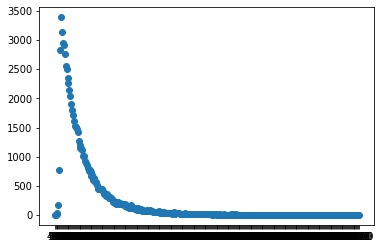

In [27]:
plt_values =  true_user_df['click_times_count'].value_counts().sort_index()
pd.set_option('display.max_rows', 100)
print(plt_values)
pd.set_option('display.max_rows', 6)
x = [str(i) for i in plt_values.index]
y = plt_values.values
plt.scatter(x,y)
plt.show()

10.0     2423
11.0     3349
12.0     3073
13.0     2880
14.0     2853
15.0     2724
16.0     2569
17.0     2367
18.0     2290
19.0     2271
20.0     2115
21.0     2013
22.0     1929
23.0     1815
24.0     1684
25.0     1633
26.0     1490
27.0     1501
28.0     1414
29.0     1487
30.0     1339
31.0     1171
32.0     1182
33.0     1167
34.0     1112
35.0     1068
36.0      978
37.0      950
38.0      897
39.0      842
40.0      839
41.0      846
42.0      735
43.0      751
44.0      694
45.0      701
46.0      622
47.0      619
48.0      626
49.0      609
50.0      545
51.0      525
52.0      513
53.0      431
54.0      445
55.0      467
56.0      411
57.0      392
58.0      403
59.0      404
         ... 
337.0       1
338.0       1
339.0       1
341.0       1
349.0       2
351.0       2
352.0       1
355.0       1
356.0       1
359.0       2
361.0       1
363.0       2
368.0       1
372.0       1
375.0       1
378.0       1
380.0       1
382.0       1
383.0       1
386.0       1
390.0 

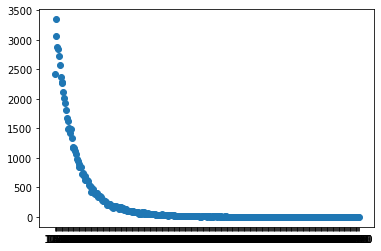

In [28]:
plt_values =  true_user_df['click_times_sum'].value_counts().sort_index()
pd.set_option('display.max_rows', 100)
print(plt_values)
pd.set_option('display.max_rows', 6)
x = [str(i) for i in plt_values.index]
y = plt_values.values
plt.scatter(x,y)
plt.show()

2.0    22872
1.0    18301
3.0    11095
       ...  
7.0     1567
8.0     1331
9.0     1081
Name: age, Length: 10, dtype: int64


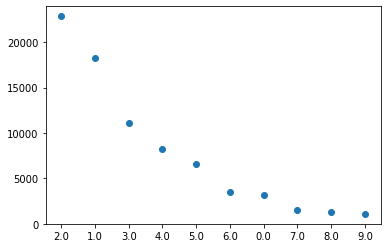

In [29]:
plt_values =  true_user_df['age'].value_counts()
print(plt_values)
x = [str(i) for i in plt_values.index]
y = plt_values.values
plt.scatter(x,y)
plt.show()

In [30]:
valid_user_base_statics_df =  user_base_statics_df[user_base_statics_df.user_id > 720000]
print(valid_user_base_statics_df)

         user_id  click_times_sum  click_times_count  ad_id_nunique  product_id_nunique  ...  industry_nunique  age  gender  click_times_sum_log  click_times_count_log
720000  720001.0             32.0               28.0           26.0                11.0  ...              11.0  2.0     2.0             3.465736               3.332205
720001  720002.0             29.0               29.0           26.0                 2.0  ...              19.0  1.0     2.0             3.367296               3.367296
720002  720003.0             21.0               20.0           17.0                 8.0  ...              10.0  1.0     1.0             3.044522               2.995732
...          ...              ...                ...            ...                 ...  ...               ...  ...     ...                  ...                    ...
899997  899998.0             15.0               14.0           14.0                 5.0  ...               5.0  3.0     2.0             2.708050               2

         user_id  click_times_sum  click_times_count  ad_id_nunique  product_id_nunique  ...  industry_nunique  age  gender  click_times_sum_log  click_times_count_log
720000  720001.0             32.0               28.0           26.0                11.0  ...              11.0  2.0     2.0             3.465736               3.332205
720001  720002.0             29.0               29.0           26.0                 2.0  ...              19.0  1.0     2.0             3.367296               3.367296
720002  720003.0             21.0               20.0           17.0                 8.0  ...              10.0  1.0     1.0             3.044522               2.995732
...          ...              ...                ...            ...                 ...  ...               ...  ...     ...                  ...                    ...
899997  899998.0             15.0               14.0           14.0                 5.0  ...               5.0  3.0     2.0             2.708050               2

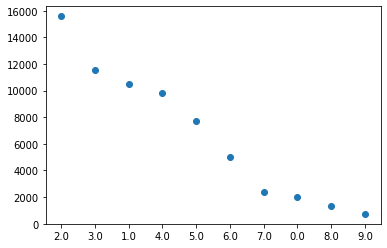

In [31]:
len_10_30_df = valid_user_base_statics_df[valid_user_base_statics_df.click_times_count > 10]
len_10_30_df = len_10_30_df[len_10_30_df.click_times_count <=20]
print(valid_user_base_statics_df)
plt_values =  len_10_30_df['age'].value_counts()
print(plt_values)
x = [str(i) for i in plt_values.index]
y = plt_values.values
plt.scatter(x,y)
plt.show()

2.0    40771
3.0    30059
1.0    29834
       ...  
7.0     6392
8.0     3856
9.0     2310
Name: age, Length: 10, dtype: int64


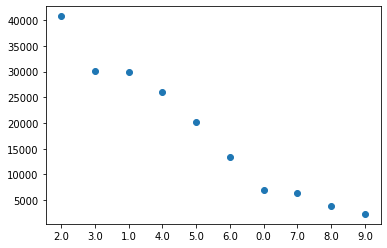

In [32]:

plt_values =  valid_user_base_statics_df['age'].value_counts()
print(plt_values)
x = [str(i) for i in plt_values.index]
y = plt_values.values
plt.scatter(x,y)
plt.show()

4.0           3
5.0           5
6.0          28
7.0         117
8.0         471
9.0        2080
10.0       7395
11.0       8741
12.0       8128
13.0       7680
14.0       7294
15.0       6769
16.0       6258
17.0       5960
18.0       5539
19.0       5265
20.0       5060
21.0       4629
22.0       4408
23.0       4125
24.0       3957
25.0       3686
26.0       3464
27.0       3336
28.0       3295
29.0       3148
30.0       2891
31.0       2686
32.0       2600
33.0       2532
34.0       2431
35.0       2297
36.0       2127
37.0       2019
38.0       1982
39.0       1857
40.0       1760
41.0       1688
42.0       1626
43.0       1604
44.0       1452
45.0       1395
46.0       1316
47.0       1323
48.0       1196
49.0       1188
50.0       1067
51.0        979
52.0       1005
53.0       1001
           ... 
376.0         1
384.0         2
388.0         1
389.0         2
390.0         1
392.0         1
393.0         1
395.0         1
396.0         1
403.0         1
406.0         1
408.0   

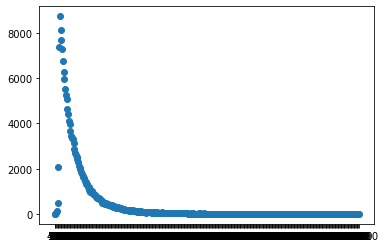

In [33]:
plt_values =  valid_user_base_statics_df['click_times_count'].value_counts().sort_index()
pd.set_option('display.max_rows', 100)
print(plt_values)
pd.set_option('display.max_rows', 6)
x = [str(i) for i in plt_values.index]
y = plt_values.values
plt.scatter(x,y)
plt.show()

10.0       6361
11.0       8682
12.0       7974
13.0       7563
14.0       7204
15.0       6648
16.0       6265
17.0       5880
18.0       5490
19.0       5312
20.0       4943
21.0       4578
22.0       4551
23.0       4151
24.0       3912
25.0       3752
26.0       3484
27.0       3343
28.0       3231
29.0       3197
30.0       2957
31.0       2683
32.0       2620
33.0       2585
34.0       2470
35.0       2320
36.0       2265
37.0       2103
38.0       1985
39.0       1899
40.0       1840
41.0       1735
42.0       1609
43.0       1636
44.0       1562
45.0       1472
46.0       1354
47.0       1322
48.0       1295
49.0       1269
50.0       1152
51.0       1139
52.0       1094
53.0        935
54.0        962
55.0        997
56.0        864
57.0        832
58.0        819
59.0        845
           ... 
430.0         2
432.0         1
438.0         1
441.0         2
449.0         1
450.0         1
452.0         1
453.0         1
461.0         2
462.0         2
467.0         1
474.0   

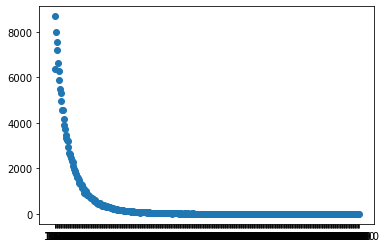

In [34]:
plt_values =  valid_user_base_statics_df['click_times_sum'].value_counts().sort_index()
pd.set_option('display.max_rows', 100)
print(plt_values)
pd.set_option('display.max_rows', 6)
x = [str(i) for i in plt_values.index]
y = plt_values.values
plt.scatter(x,y)
plt.show()

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


         user_id  click_times_sum  click_times_count  ad_id_nunique  product_id_nunique  ...  industry_nunique  age  gender  click_times_sum_log  click_times_count_log
720000  720001.0             32.0               28.0           26.0                11.0  ...              11.0  2.0     2.0             3.465736               3.332205
720001  720002.0             29.0               29.0           26.0                 2.0  ...              19.0  1.0     2.0             3.367296               3.367296
720002  720003.0             21.0               20.0           17.0                 8.0  ...              10.0  1.0     1.0             3.044522               2.995732
...          ...              ...                ...            ...                 ...  ...               ...  ...     ...                  ...                    ...
899997  899998.0             15.0               14.0           14.0                 5.0  ...               5.0  3.0     2.0             2.708050               2

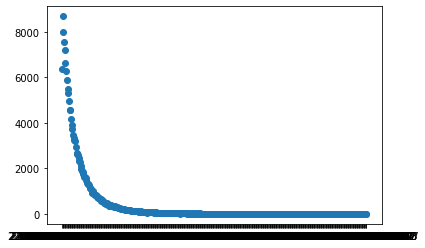

In [35]:
valid_user_base_statics_df['click_times_sum_log'] =  valid_user_base_statics_df['click_times_sum'].apply(lambda x: math.log(x))
print(valid_user_base_statics_df)
plt_values =  valid_user_base_statics_df['click_times_sum_log'].value_counts().sort_index()
pd.set_option('display.max_rows', 100)
print(plt_values)
pd.set_option('display.max_rows', 6)
x = [str(i) for i in plt_values.index]
y = plt_values.values
plt.scatter(x,y)
plt.show()

In [36]:
print(valid_user_base_statics_df)

         user_id  click_times_sum  click_times_count  ad_id_nunique  product_id_nunique  ...  industry_nunique  age  gender  click_times_sum_log  click_times_count_log
720000  720001.0             32.0               28.0           26.0                11.0  ...              11.0  2.0     2.0             3.465736               3.332205
720001  720002.0             29.0               29.0           26.0                 2.0  ...              19.0  1.0     2.0             3.367296               3.367296
720002  720003.0             21.0               20.0           17.0                 8.0  ...              10.0  1.0     1.0             3.044522               2.995732
...          ...              ...                ...            ...                 ...  ...               ...  ...     ...                  ...                    ...
899997  899998.0             15.0               14.0           14.0                 5.0  ...               5.0  3.0     2.0             2.708050               2

In [37]:
false_user_df = ret_df[ret_df.predicted_age != ret_df.label_age ]
false_user_df = false_user_df.merge(user_base_statics_df,on='user_id')
print(false_user_df)

        user_id  predicted_age                                                                                                                                            age_percent  label_age  click_times_sum  ...  industry_nunique  age  gender  click_times_sum_log  \
0        720005              1  [0.025847079467356572, 0.33250477190534455, 0.3317819585195014, 0.11858391327084938, 0.08284980747146425, 0.07027751131719932, 0.03055719834116464...          4             24.0  ...              14.0  4.0     1.0             3.178054   
1        720007              2  [0.003575759149017563, 0.14110571629106355, 0.46906207020079776, 0.34167234118819223, 0.03704864457441785, 0.004623358454487037, 0.001544381659597...          3             18.0  ...              11.0  3.0     1.0             2.890372   
2        720009              2  [0.0012245536607584883, 0.17798264862359084, 0.47657452873507833, 0.22118429055467229, 0.09965622463390661, 0.016228283044437693, 0.00640877488144...         

4.0           2
5.0           3
6.0          13
7.0          82
8.0         293
9.0        1300
10.0       4564
11.0       5349
12.0       4995
13.0       4727
14.0       4373
15.0       4013
16.0       3702
17.0       3463
18.0       3186
19.0       2994
20.0       2915
21.0       2596
22.0       2509
23.0       2326
24.0       2237
25.0       2075
26.0       1935
27.0       1828
28.0       1817
29.0       1728
30.0       1618
31.0       1488
32.0       1453
33.0       1391
34.0       1322
35.0       1285
36.0       1121
37.0       1101
38.0       1088
39.0       1008
40.0        958
41.0        926
42.0        846
43.0        868
44.0        781
45.0        712
46.0        716
47.0        693
48.0        627
49.0        619
50.0        554
51.0        532
52.0        536
53.0        552
           ... 
340.0         2
341.0         2
342.0         3
343.0         1
345.0         2
346.0         2
349.0         1
350.0         3
351.0         1
354.0         1
355.0         2
357.0   

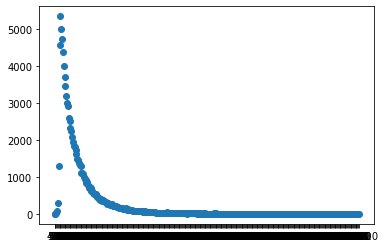

In [38]:
plt_values =  false_user_df['click_times_count'].value_counts().sort_index()
pd.set_option('display.max_rows', 100)
print(plt_values)
pd.set_option('display.max_rows', 6)
x = [str(i) for i in plt_values.index]
y = plt_values.values
plt.scatter(x,y)
plt.show()